# <center> Modélisation

In [1]:
%run "./Ouverture_donnees.ipynb"

Les importations nécessaires à la modélisation : 

In [93]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import svm
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn import tree

In [3]:
#df_accidents.columns

Dans cette section, nous cherchons à prédire la gravité de l'accident grâce aux variables explicatives telles que le type de la collision, le type de la route, la luminosité, etc. \
Pour cela, notre variable cible s'appelle "gravite", elle vaut 1 si lors de l'accident, il y a eu au moins un blessé hospitalisé et/ou une personne tuée et elle vaut 0 sinon (les usagers sont soit indemnes, soit des blessés légers).

## Préparation des données

Pour une meilleure modélisation, il est essentiel d'avoir un nombre de modalités raisonnable. Ainsi, nous regroupons les modalités ensemble si elles correspondent à un pourcentage d'accidents graves proche.

In [4]:
# Mettre des modalités ensemble :
df_accidents["collision"] = df_accidents["collision"].replace(["2 - frontale", "2-arriere", "3 vehicules", "2-cote"], "2 ou 3 véhicules")

df_accidents["catr"] = df_accidents["catr"].replace(["Route départementale", "Route nationale", "Autre"], "Route départementale ou nationale + Autre")
df_accidents["catr"] = df_accidents["catr"].replace(["Autoroute", "Voie Communale"], "Autoroute + Voie Communale")

df_accidents["lum"] = df_accidents["lum"].replace(["Crépuscule ou aube"], "Plein jour")

## Sélection de variables
Dans un premier temps, on étudie le pouvoir prédictif des variables explicatives. \
Le V de Cramer mesure l'association entre la variable explicative et la variable cible "gravité". On a réalisé un test d'indépendance du Chi-2. Si la p-valeur est inférieur à 0.05, alors l'hypothèse nulle d'indépendance est rejetée et il existe une dépendance entre la variable explicative et la variable cible. \
On retrouve ci-dessous les différentes valeurs de V de Cramer et de p-valeurs.

In [5]:
colonne = ["agglo", "lum", "int", "collision", "atm", "catr", "circ", "surf", "prof", "plan", "infra", "situ"]

def cramers(df):
    L_cramer = []
    L_pvalue = []
    L_var = []
    for elem in colonne :
        crosstab = pd.crosstab(df[elem], df.gravite, margins = True, normalize = 'index')*100
        chi2 = ss.chi2_contingency(crosstab)[0]
        p_value = round(ss.chi2_contingency(crosstab)[1], 3)
        n = sum(crosstab.sum())
        VCramer = round(np.sqrt(chi2 / (n*(min(crosstab.shape)-1))), 3)
        #print("Pour la variable " + elem + ", le V de Cramer est : " + VCramer.astype(str))
        #print("La p-valeur du test du Chi-2 est : " + p_value.astype(str))
        L_cramer.append(VCramer)
        L_pvalue.append(p_value)
        L_var.append(elem)
    tableau = np.array([L_cramer, L_pvalue])
    pd_tableau = pd.DataFrame(tableau.T, index = L_var, columns = ['V de Cramer', 'p_value'])
    return pd_tableau.sort_values("p_value")

cramers(df_accidents)

,V de Cramer,p_value
situ,0.288,0.000
agglo,0.209,0.001
catr,0.221,0.001
circ,0.200,0.001
lum,0.191,0.002
plan,0.151,0.032
collision,0.139,0.051
prof,0.095,0.261
atm,0.080,0.465
int,0.072,0.552


Ainsi, les variables utilisées seront Catr (le type de route), Situ (lieu de l'accident), Agglo (si l'accident a lieu en agglomération), Circ (le sens de circulation), Lum (la lminosité), plan (si la route est rectiligne ou courbée) et collision.

Créer les indicatrices nécessaires

In [6]:
# Variable cible :
df_accidents["y"] = (df_accidents["gravite"]==2).astype(int)


# Variables explicatives :
df_accidents["Sans collision"] = pd.get_dummies(df_accidents["collision"])["Sans collision"]
df_accidents["Autre collision"] = pd.get_dummies(df_accidents["collision"])["autre"]

df_accidents["Route dep ou nationale"] = pd.get_dummies(df_accidents["catr"])["Route départementale ou nationale + Autre"]

df_accidents["Sur accotement"] = pd.get_dummies(df_accidents["situ"])["Sur accotement"]
df_accidents["Autre lieu de l'accident"] = pd.get_dummies(df_accidents["situ"])["Autre"]

df_accidents["Hors agglomeration"] = pd.get_dummies(df_accidents["agglo"])["Hors agglomeration"]

df_accidents["A chaussées séparées"] = pd.get_dummies(df_accidents["circ"])["A chaussées séparées"]
df_accidents["Bidirectionnelle"] = pd.get_dummies(df_accidents["circ"])["Bidirectionnelle"]

df_accidents["Nuit sans éclairage"] = pd.get_dummies(df_accidents["lum"])["Nuit sans éclairage public"]
df_accidents["Plein jour"] = pd.get_dummies(df_accidents["lum"])["Plein jour"]

df_accidents["Courbe"] = pd.get_dummies(df_accidents["plan"])["Courbe"]

In [128]:
#data = pd.get_dummies(df_accidents[col],drop_first=True)

Créer les échantillons de test et d'apprentissage

In [10]:
# Les variables explicatives sous forme d'indicatrices
col = ["Route dep ou nationale", "Sur accotement", "Autre lieu de l'accident", "Hors agglomeration",
       "A chaussées séparées", "Bidirectionnelle", "Nuit sans éclairage", "Plein jour",
       "Sans collision", "Autre collision", "Courbe"]

# Créer de la base de donner avec uniquement les variables explicatives
df_temp = df_accidents[col]

# Création des échantillons de test et d'apprentissage
xTrain, xTest, yTrain, yTest = train_test_split(df_temp, df_accidents["y"].values.ravel(), test_size = 0.2, random_state = 0)

## Modélisation et performance du modèle

Nous allons étudier différents types de modèles :
* Classification
* Régression linéaire
* Arbre de décision

Pour cela, nous codons des fonctions pour tracer les courbes ROC et les matrices de confusion.

### Fonctions utiles

In [101]:
def courbe_roc(modele) :
    prob_sans_modele = [0 for _ in range(len(yTest))]
    # predict probabilities
    prob_pred = modele.predict_proba(xTest)
    # keep probabilities for the positive outcome only
    prob_pred = prob_pred[:, 1]
    # calculate scores
    auc_sans_modele = roc_auc_score(yTest, prob_sans_modele)
    auc = roc_auc_score(yTest, prob_pred)
    # summarize scores
    print('Modèle aléatoire : ROC AUC=%.3f' % (auc_sans_modele))
    print('Modèle logistique : ROC AUC=%.3f' % (auc))
    # calculate roc curves
    fpr_sans_modele, tpr_sans_modele, _ = roc_curve(yTest, prob_sans_modele)
    fpr, tpr, _ = roc_curve(yTest, prob_pred)
    # plot the roc curve for the model
    plt.plot(fpr_sans_modele, tpr_sans_modele, linestyle='--', label='Modèle aléatoire')
    plt.plot(fpr, tpr, label='Modèle logistique')
    # axis labels
    plt.xlabel('Taux de vrais positifs')
    plt.ylabel('Taux de faux positifs')
    # show the legend
    plt.legend()
    # show the plot
    plt.show() 

In [102]:
#Fonction servant à comparer graphiquement les courbes ROC de différents modèles de classification
def courbe_roc_synthese(modele1,modele2,modele3) :
    prob_sans_modele = [0 for _ in range(len(yTest))]
    # predict probabilities
    prob_pred1 = modele1.predict_proba(xTest)
    prob_pred2 = modele2.predict_proba(xTest)
    prob_pred3 = modele3.predict_proba(xTest)
    # keep probabilities for the positive outcome only
    prob_pred1 = prob_pred1[:, 1]
    prob_pred2 = prob_pred2[:, 1]
    prob_pred3 = prob_pred3[:, 1]
    # calculate scores
    auc_sans_modele = roc_auc_score(yTest, prob_sans_modele)
    auc1 = roc_auc_score(yTest, prob_pred1)
    auc2 = roc_auc_score(yTest, prob_pred2)
    auc3 = roc_auc_score(yTest, prob_pred3)
    # summarize scores
    print('Modèle aléatoire : ROC AUC=%.3f' % (auc_sans_modele))
    print('Modèle logistique : ROC AUC=%.3f' % (auc1))
    print('Modèle logistique : ROC AUC=%.3f' % (auc2))
    print('Modèle logistique : ROC AUC=%.3f' % (auc3))
    # calculate roc curves
    fpr_sans_modele, tpr_sans_modele, _ = roc_curve(yTest, prob_sans_modele)
    fpr1, tpr1, _ = roc_curve(yTest, prob_pred1)
    fpr2, tpr2, _ = roc_curve(yTest, prob_pred2)
    fpr3, tpr3, _ = roc_curve(yTest, prob_pred3)
    # plot the roc curve for the model
    plt.plot(fpr_sans_modele, tpr_sans_modele, linestyle='--', label='Modèle aléatoire')
    plt.plot(fpr1, tpr1, label='Modèle logistique SVC')
    plt.plot(fpr2, tpr2, label='Modèle logistique SGD')
    plt.plot(fpr3, tpr3, label='Modèle logistique KNN')
    # axis labels
    plt.xlabel('Taux de vrais positifs')
    plt.ylabel('Taux de faux positifs')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [12]:
def matrice_confusion(modele) :
    sklearn.metrics.plot_confusion_matrix(modele, xTest, yTest)
    plt.show()

### Classification

Nous testons les modèles de classification suivants:
- Linear SVC
- SGD Classifier
- KNeighbors Classifier  

pour déterminer celui le plus précis et le plus adapté à notre base de données

###### 1. Modèle Linear SVC

Entrainement d'un classifieur SVM avec comme paramètre de régularisation C=1

In [68]:
classification_SVC = svm.SVC(kernel='linear', C=1, probability = True).fit(xTrain, yTrain)
y_pred = classification_SVC.predict(xTest)

Calcul des indicateurs

In [72]:
sc_accuracy_SVC = sklearn.metrics.accuracy_score(y_pred, yTest)
sc_precision_SVC = sklearn.metrics.precision_score(y_pred, yTest)
sc_recall_SVC = sklearn.metrics.recall_score(y_pred, yTest)
sc_f1_SVC = sklearn.metrics.f1_score(y_pred, yTest)
print(sc_accuracy_SVC)
print(sc_precision_SVC)
print(sc_recall_SVC)
print(sc_f1_SVC)

0.7164709517923362
0.44371561574269996
0.6682600382409177
0.5333163784333673


Tracé de la courbe ROC

Modèle aléatoire : ROC AUC=0.500
Modèle logistique : ROC AUC=0.724


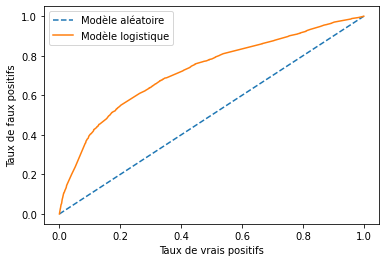

In [73]:
courbe_roc(classification_SVC)

Détermination de la matrice de confusion

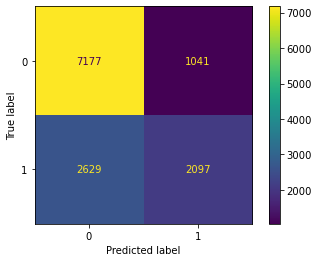

In [74]:
matrice_confusion(classification_SVC)

Ainsi, si la mesure de précision (0.72) et la courbe ROC sont plutôt satisfaisantes, la F-mesure (0.53) pourrait être améliorée et la matrice de confusion montre une proportion de faux négatifs assez élevée.

###### 2. Modèle SGD Classifier

Entrainement d'un classifieur SGD, avec calibrement du classifieur afin de calculer les probabilités des valeurs, nécessaires au tracé de la courbe ROC

In [76]:
classification_SGD = SGDClassifier(max_iter=1000, tol=0.001)
calibrated_classification_SGD = CalibratedClassifierCV(classification_SGD, cv=5, method='sigmoid').fit(xTrain,yTrain)
y_pred = calibrated_classification_SGD.predict(xTest)

Calcul des indicateurs

In [78]:
sc_accuracy_SGD = sklearn.metrics.accuracy_score(y_pred, yTest)
sc_precision_SGD = sklearn.metrics.precision_score(y_pred, yTest)
sc_recall_SGD = sklearn.metrics.recall_score(y_pred, yTest)
sc_f1_SGD = sklearn.metrics.f1_score(y_pred, yTest)
print(sc_accuracy_SGD)
print(sc_f1_SGD)
print(sc_recall_SGD)
print(sc_precision_SGD)

0.7178615574783683
0.5194736842105263
0.6868475991649269
0.41768937790943717


Tracé de la courbe ROC

Modèle aléatoire : ROC AUC=0.500
Modèle logistique : ROC AUC=0.722


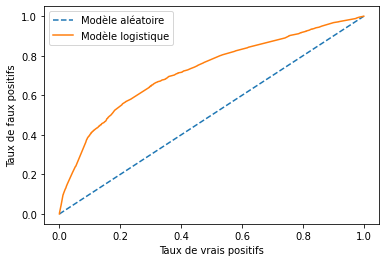

In [81]:
courbe_roc(calibrated_classification_SGD)

Détermination de la matrice de confusion

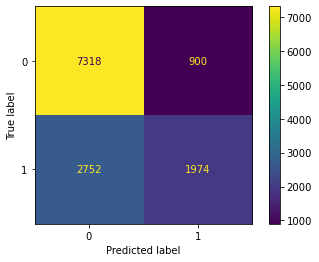

In [82]:
matrice_confusion(calibrated_classification_SGD)

Ainsi, comme le modèle Linear SVC, la mesure de précision (0.72) et la courbe ROC sont plutôt satisfaisantes mais la F-mesure (0.42) pourrait être améliorée. La matrice de confusion montre également une proportion de faux négatifs assez élevée.

###### 3. Modèle KNeighbors Classifier

Entrainement d'un classifieur KNeighbors

In [83]:
classification_KNN = KNeighborsClassifier(n_neighbors = 5).fit(xTrain,yTrain)
y_pred = classification_KNN.predict(xTest)

Calcul des indicateurs

In [84]:
sc_accuracy_KNN = sklearn.metrics.accuracy_score(y_pred, yTest)
sc_precision_KNN = sklearn.metrics.precision_score(y_pred, yTest)
sc_recall_KNN = sklearn.metrics.recall_score(y_pred, yTest)
sc_f1_KNN = sklearn.metrics.f1_score(y_pred, yTest)
print(sc_accuracy_KNN)
print(sc_precision_KNN)
print(sc_recall_KNN)
print(sc_f1_KNN)

0.6736711990111248
0.32331781633516715
0.5982772122161315
0.4197802197802198


Tracé de la courbe ROC

Modèle aléatoire : ROC AUC=0.500
Modèle logistique : ROC AUC=0.622


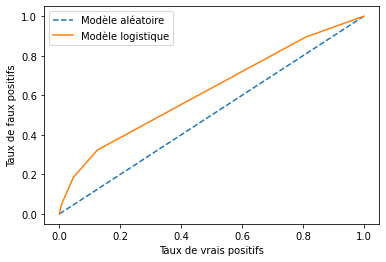

In [85]:
courbe_roc(classification_KNN)

Détermination de la matrice de confusion

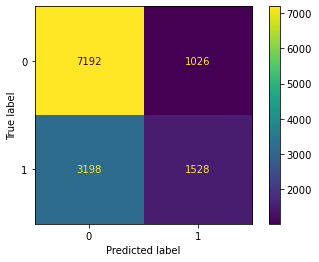

In [87]:
matrice_confusion(classification_KNN)

Ainsi, les indicateurs et notamment la mesure de précision (0.67) et la F-mesure (0.42) sont inférieurs aux indicateurs des 2 précédents modèles. La courbe ROC est nettement moins satisfaisante que les autres courbes ROC. Le Modèle KNeighbors Classifier est donc moins adapté à nos données.

###### 4. Synthèse des modèles testés

On dresse un tableau récapitulatif des indicateurs obtenus lors des différents tests.

In [99]:
data = array([[sc_accuracy_SVC, sc_precision_SVC, sc_recall_SVC, sc_f1_SVC],
             [sc_accuracy_SGD, sc_precision_SGD, sc_recall_SGD, sc_f1_SGD],
             [sc_accuracy_KNN, sc_precision_KNN, sc_recall_KNN, sc_f1_KNN]])
columns = ['Accuracy', 'Precision', 'Recall', 'F1']
index = ['Linear SVC', 'SGD Classifier', 'KNeighbors Classifier']
tableau = pd.DataFrame(data=data,index=index,columns=columns)
tableau

,Accuracy,Precision,Recall,F1
Linear SVC,0.716471,0.443716,0.668260,0.533316
SGD Classifier,0.717862,0.417689,0.686848,0.519474
KNeighbors Classifier,0.673671,0.323318,0.598277,0.419780


Nous superposons les courbes ROC sur un même graphe afin de déterminer le modèle le plus satisfaisant.

Modèle aléatoire : ROC AUC=0.500
Modèle logistique : ROC AUC=0.724
Modèle logistique : ROC AUC=0.722
Modèle logistique : ROC AUC=0.622


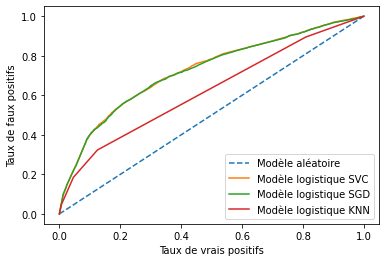

In [104]:
courbe_roc_synthese(classification_SVC, calibrated_classification_SGD, classification_KNN)

En conclusion de cette partie Classification, le graphe ci-dessus nous permet de suite d'éliminer le modèle KNeighbors Classifier, mais il ne nous permet pas de départager entre le modèle Linear SVC et le modèle SGD Classifier. Le tableau récapitulatif des indicateurs de précision montre que le modèle Linear SVC a une F-mesure (0.53) un petit peu plus supérieure que celle du modèle SGD Classifier (0.52).  
Les modèles Linear SVC et SGD Classifier sont donc équivalents, mais le modèle Linear SVC apparait un petit peu plus adapté à nos données.

### Régression logistique

In [11]:
import statsmodels as sm
from statsmodels.tools import add_constant
XTrainBis = sm.tools.add_constant(xTrain)
print(XTrainBis.info())

from statsmodels.api import Logit
#régression logistique - on passe la cible et les explicatives
modele_logistique = Logit(endog=yTrain,exog=XTrainBis).fit()

/Users/cloclo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 47072 entries, 126521 to 6056
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   const                     47072 non-null  float64
 1   Route dep ou nationale    47072 non-null  uint8  
 2   Sur accotement            47072 non-null  uint8  
 3   Autre lieu de l'accident  47072 non-null  uint8  
 4   Hors agglomeration        47072 non-null  uint8  
 5   A chaussées séparées      47072 non-null  uint8  
 6   Bidirectionnelle          47072 non-null  uint8  
 7   Nuit sans éclairage       47072 non-null  uint8  
 8   Plein jour                47072 non-null  uint8  
 9   Sans collision            47072 non-null  uint8  
 10  Autre collision           47072 non-null  uint8  
 11  Courbe                    47072 non-null  uint8  
dtypes: float64(1), uint8(11)
memory usage: 1.2 MB
None
Optimization terminated successfully.
         Current functi

In [14]:
print(modele_logistique.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                47072
Model:                          Logit   Df Residuals:                    47060
Method:                           MLE   Df Model:                           11
Date:                Tue, 28 Dec 2021   Pseudo R-squ.:                  0.1362
Time:                        13:52:07   Log-Likelihood:                -26619.
converged:                       True   LL-Null:                       -30818.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.2406      0.038    -59.425      0.000      -2.315      -2.167
Route dep ou nationale       0.7660      0.022     34.347      0.000       0.722       0.

On remarque que les variables "A chaussées séparées" et "Plein jour" ne sont pas significatives au seuil de 5%.

### Arbre de décision